# NFL Injury Patterns (Work In Progress)

This is a detailed look at the injuries that occur in the NFL. This analysis seeks to answer the following questions:

- What types of injuries are most common?
- Who is getting what injuries?
- When are injuries most common?
- Which injuries are the most severe?
- Which teams are most accurate in their injury reporting?

## Prerequisites

Before we begin, let's change our working directory to the root of the project so that we can reuse this project's Python code.

In [1]:
%cd ..

/home/pradyothkukkapalli/Projects/nfldata


Now, let's import some libraries:

- `%matplotlib inline`: instruct Jupyter to show all plots inline.
- [`sqlite3`][sqlite]: the data for this analysis is in `nfldata.sqlite`, and this library allows us to query it.
- [`pandas`][pandas]: a data analysis library that will make the SQLite data easier to manipulate.
- [`seaborn`][seaborn]: produces graphs and visualizations easily for `pandas` `DataFrame`s.
- [`pyplot`][pyplot]: the backend for `seaborn`. Needed in order to customize visualizations.
- `nfldata.analysis.tables`: a module defined in this project that defines a few helpful utilities to cut down on repetitive code.

[sqlite]: https://docs.python.org/3/library/sqlite3.html
[pandas]: https://pandas.pydata.org/
[seaborn]: https://seaborn.pydata.org/
[pyplot]:https://matplotlib.org/api/pyplot_api.html

In [2]:
%matplotlib inline
import sqlite3
import pandas
from matplotlib import pyplot
import seaborn
from nfldata.analysis.tables import print_schema

All of the data for this analysis was sourced from [Pro Football Reference][pfr] using [Scrapy][scrapy]. The data is stored as a [SQLite][sqlite] in the `nfldata.sqlite` file at the root of the project. Here we will initialize the connection to the database for use throughout this notebook.

[pfr]:https://www.pro-football-reference.com/
[scrapy]:https://scrapy.org/
[sqlite]:https://www.sqlite.org/index.html

In [3]:
database = sqlite3.connect('nfldata.sqlite')

## Most common injuries

Now, let's start with a simple analysis. What are the top 20 most common injuries on injury reports? The data is stored in two tables, `injuries` and `injury_reasons`. First, let's examine the `injuries` table schema:

- `player`: A unique ID for the injured player.
- `team`: A unique ID for the team the player was playing on. The ID also encodes the year that the event occurred.
- `week`: The week of the season the injury happened.
- `status`: The listed status on the injury report, i.e. Probable, Questionable, Out, etc.
- `outcome`: Whether the player ended up playing that week or not.

In [4]:
print_schema(database, 'injuries')

CREATE TABLE injuries (
                player TEXT,
                team TEXT,
                week INTEGER,
                status TEXT,
                outcome TEXT,
                PRIMARY KEY (player, team, week),
                FOREIGN KEY (player) REFERENCES players(player),
                FOREIGN KEY (team) REFERENCES teams(team)
            )


Second, let's examine the `injury_reasons` table schema:

- `player`: Same as above.
- `team`: Same as above.
- `week`: Same as above.
- `reason`: The reason for the entry in the injury report. Now you may be wondering why these are in a separate table. It is because a single player may have multiple reasons for being injured. For example, they may have an ankle sprain and a concussion. Since SQLite doesn't support array columns, I broke the reasons out into a separate table.

In [5]:
print_schema(database, 'injury_reasons')

CREATE TABLE injury_reasons (
                player TEXT,
                team TEXT,
                week INTEGER,
                reason TEXT,
                PRIMARY KEY (player, team, week),
                FOREIGN KEY (player) REFERENCES players(player),
                FOREIGN KEY (team) REFERENCES teams(team),
                FOREIGN KEY (player, team, week) 
                    REFERENCES injuries(player, team, week)
            )


Now, let's take a look at the frequency of each injury. Here, we will be joining the two tables on the common columns, `player`, `team` and `week`, and counting the number of rows after grouping by `reason`. We will be reading the data into a `DataFrame` object provided by the `pandas` library, which makes it easy to visualize the table as a table, and later as part of a graph.

In this analysis, we see that the top 10 reasons for injuries are the knee (by a wide margin), ankle, undisclosed (i.e. the report did not specify), hamstring, shoulder, foot, concussion, back, groin, and achilles tendon. The `reason` column in the `injury_reasons` table is not one to one with what is actually written in the injury report. I grouped together many actual reasons given to provide some reasonable aggregation without having a long tail of injuries that had < 10 occurrences. Take a look at the `PFR_INJURY_REASON_SUBSTITUTIONS` `dict` in the `nfldata.items.injuries` module of this project.

At first glance, none of the injuries on this list are too surprising. The [knee is well known as the most susceptible joints][epidemiology-knee] when it comes to sports injuries.

[epidemiology-knee]:https://www.sciencedirect.com/science/article/abs/pii/S0968016006000032

In [6]:
reason_frequency = pandas.read_sql_query('''
    SELECT LOWER(reason) as reason, count(*) as frequency 
    FROM injuries JOIN injury_reasons USING (player, team, week)
    GROUP BY reason
    ORDER BY frequency DESC;
''', database)
reason_frequency.head(10)

,reason,frequency
0,knee,20762
1,ankle,9507
2,undisclosed,8860
3,hamstring,6655
4,shoulder,6582
5,foot,5005
6,concussion,3338
7,back,2849
8,groin,2733
9,achilles,2197


In fact, we can change our query slightly to see what percentage of injuries are caused by each part. The knee accounts for nearly a quarter of all injuries!

In [7]:
reason_frequency_pct = pandas.read_sql_query('''
    SELECT LOWER(reason) as reason, 
        CAST(count(*) AS REAL) * 100 / (SELECT count(*) FROM injury_reasons) as frequency_percent 
    FROM injuries JOIN injury_reasons USING (player, team, week)
    GROUP BY reason
    ORDER BY frequency_percent DESC;
''', database)
reason_frequency_pct.head(10)

,reason,frequency_percent
0,knee,22.753874
1,ankle,10.419087
2,undisclosed,9.710015
3,hamstring,7.293470
4,shoulder,7.213467
5,foot,5.485172
6,concussion,3.658243
7,back,3.122329
8,groin,2.995200
9,achilles,2.407777


We can also view this data visually quite easily using the `seaborn` library, which integrates well with `pandas`.

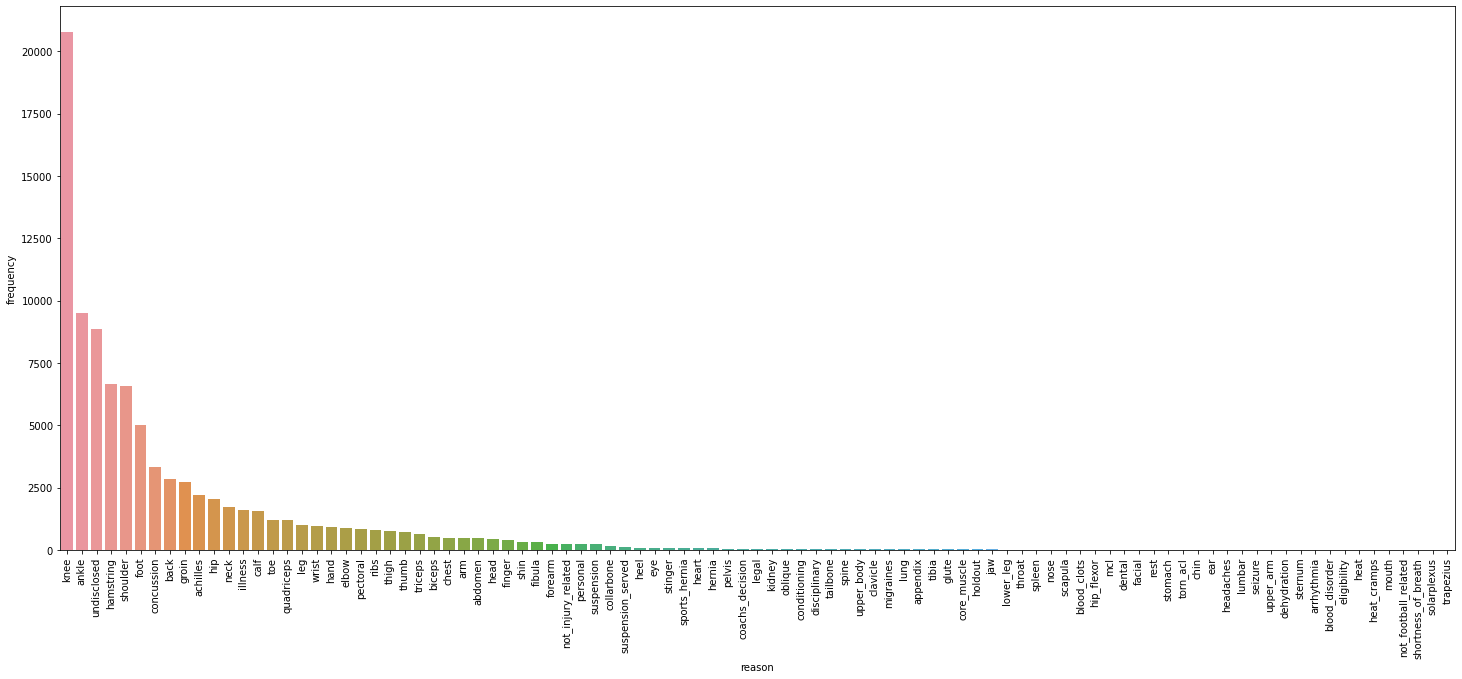

In [8]:
pyplot.figure(figsize=(25, 10))
plot = seaborn.barplot(x='reason', y='frequency', data=reason_frequency)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
pyplot.show()

This shows us which injuries are most common. However, what may be more interesting is learning which injuries cause player to miss games. We can do a similar analysis to what we did above, but using the condition that `outcome = 'DID_NOT_PLAY`. We can immediately see that the ordering of the injuries is fairly close to the ordering we get when we do not consider the outcome.

In [9]:
reason_did_not_play_frequency = pandas.read_sql_query('''
    SELECT LOWER(reason) as reason, count(*) as frequency
    FROM injuries JOIN injury_reasons USING (player, team, week)
    WHERE outcome = 'DID_NOT_PLAY'
    GROUP BY reason
    ORDER BY frequency DESC;
''', database)
reason_did_not_play_frequency.head(10)

,reason,frequency
0,knee,15798
1,undisclosed,8813
2,ankle,5891
3,hamstring,4555
4,shoulder,4091
5,foot,3688
6,concussion,2524
7,achilles,2046
8,back,1623
9,groin,1501


As above, we can also look at what percentage of games missed each injury reason is responsible for. One thing that you will notice from this table is that the percentages for the top 10 reasons are quite different than the percentages in the table above. This is like because some of the less common reasons, such as blood clots, lung, and spleen, are much more likely to keep the player out of a game.

In [10]:
reason_did_not_play_frequency_percent = pandas.read_sql_query('''
    SELECT LOWER(reason) as reason, 
        CAST(count(*) AS REAL) * 100 / (SELECT count(*) FROM injury_reasons) as frequency_percent 
    FROM injuries JOIN injury_reasons USING (player, team, week)
    WHERE outcome = 'DID_NOT_PLAY'
    GROUP BY reason
    ORDER BY frequency_percent DESC;
''', database)
reason_did_not_play_frequency_percent.head(10)

,reason,frequency_percent
0,knee,17.313636
1,undisclosed,9.658506
2,ankle,6.456173
3,hamstring,4.992000
4,shoulder,4.483484
5,foot,4.041821
6,concussion,2.766149
7,achilles,2.242290
8,back,1.778708
9,groin,1.645004


When we visualize the distribution of games missed, we see that the tail of this graph is slightly thicker than the tail of the graph above. This indicates that the less common reasons do have a higher chance of making the player miss the upcoming game.

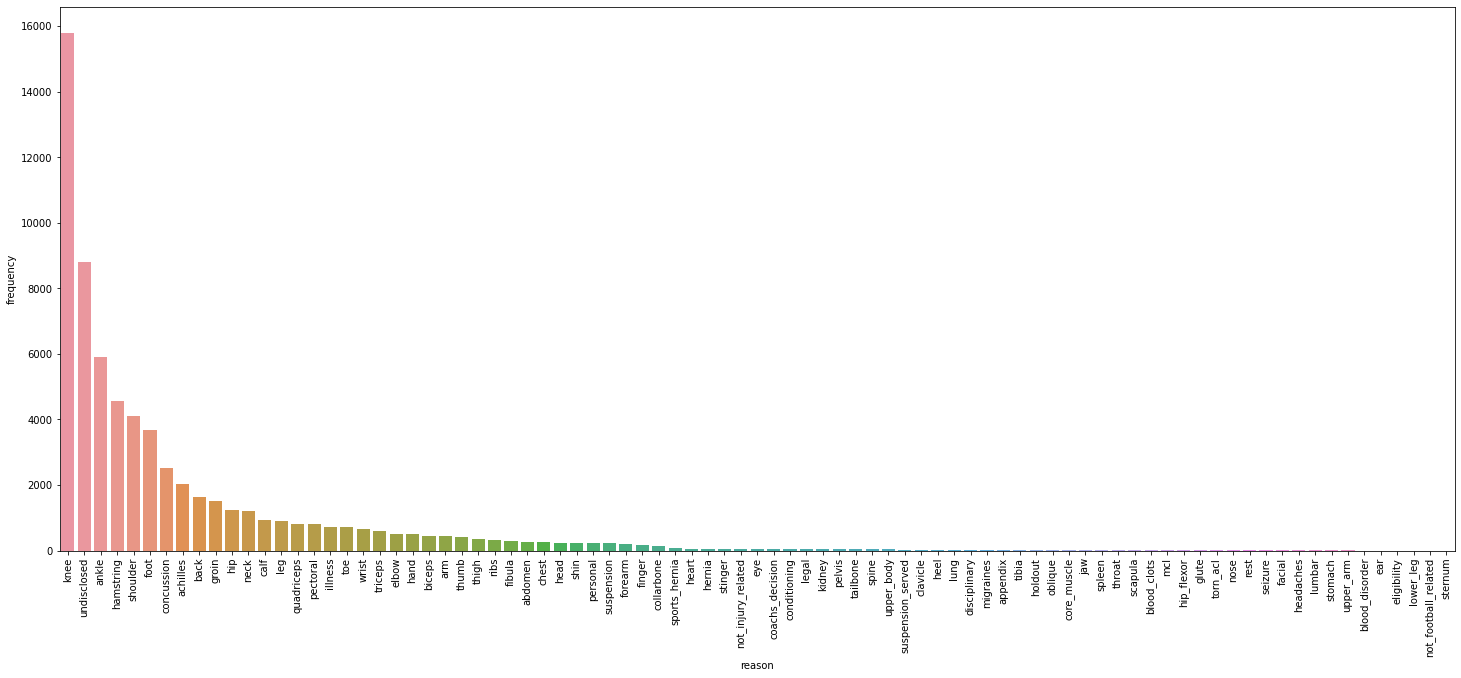

In [11]:
pyplot.figure(figsize=(25, 10))
plot = seaborn.barplot(x='reason', y='frequency', data=reason_did_not_play_frequency)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
pyplot.show()

Now, let's look at this same problem from a slightly different angle. Which injuries are most statistically likely to cause a player to miss a game? Of course we need to account for the fact that a lot of injuries have very few occurrences. So, we need to set a reasonable threshold for the minimum number of occurrences. We can determine that by seeing what percent of occurrences are captured by a given threshold. Below, we can see that 98.69% of injuries are still captured if we set the threshold at 100, so that is the threshold we will be applying going forward.

In [12]:
total = reason_frequency['frequency'].sum()
thresholds = []
for threshold in range(0, 101):
    occurrences_captured = reason_frequency[reason_frequency['frequency'] >= threshold]
    occurrences_captured = float(occurrences_captured['frequency'].sum()) * 100 / total
    thresholds.append(occurrences_captured)
thresholds = pandas.Series(thresholds)
thresholds

0      100.000000
1      100.000000
2       99.989041
3       99.984657
4       99.964930
          ...    
96      98.688162
97      98.688162
98      98.688162
99      98.688162
100     98.688162
Length: 101, dtype: float64

Now we can easily determine the statiscal chance that an injury will cause a player to miss a game by reusing our previous queries and some simple division. Keep in mind that many of these injury reasons would not even make the injury report if they were not severe. For example, a sore triceps probably would not make the report, but a torn triceps certainly would, and would almost certainly keep the player out of the game.

In [13]:
miss_probability = pandas.read_sql_query('''
    WITH occurrences AS (
        SELECT LOWER(reason) as reason, count(*) as frequency
        FROM injuries JOIN injury_reasons USING (player, team, week)
        GROUP BY reason 
    ),
    misses AS (
        SELECT LOWER(reason) as reason, count(*) as frequency
        FROM injuries JOIN injury_reasons USING (player, team, week)
        WHERE outcome = 'DID_NOT_PLAY'
        GROUP BY reason
    )
    SELECT reason, CAST(misses.frequency AS REAL) * 100 / occurrences.frequency AS miss_probability FROM
    occurrences JOIN misses USING (reason)
    WHERE occurrences.frequency >= 100
    ORDER BY miss_probability DESC
''', database)
miss_probability

,reason,miss_probability
0,undisclosed,99.469526
1,suspension,98.181818
2,triceps,95.094937
3,pectoral,94.792899
4,fibula,94.701987
5,arm,93.630573
6,achilles,93.126991
7,collarbone,92.727273
8,leg,92.113246
9,personal,88.095238


## Injuries by position

We also have the `player` and `player_positions` tables available to us. They provide basic information about players such as their name and position.

Let's first examine the table schema for `players`:

- `player`: Same as above.
- `name`: The player's full name.
- `first_team_all_pros`: The number of 1st-Team All-Pros this player achieved in their career.
- `pro_bowls`: The number of Pro Bowls this player achieved in their career.
- `career_approx_value`: The total weighted [approximate value][av] of a player across his career.

[av]:https://www.pro-football-reference.com/blog/index37a8.html

In [14]:
print_schema(database, 'players')

CREATE TABLE players (
                player TEXT PRIMARY KEY,
                name TEXT,
                first_team_all_pros INTEGER,
                pro_bowls INTEGER,
                career_approx_value INTEGER
            )


Let's also examine the table schema for `player_positions`:

- `player`: Same as above.
- `position`: A position played by this player at least once in their career. Keep in mind that a player may have multiple positions.

In [15]:
print_schema(database, 'player_positions')

CREATE TABLE player_positions (
                player TEXT,
                position TEXT,
                PRIMARY KEY (player, position),
                FOREIGN KEY (player) REFERENCES players(player)
            )


Now, let's look at the distribution of player positions across the league to see what our sample sizes are like.

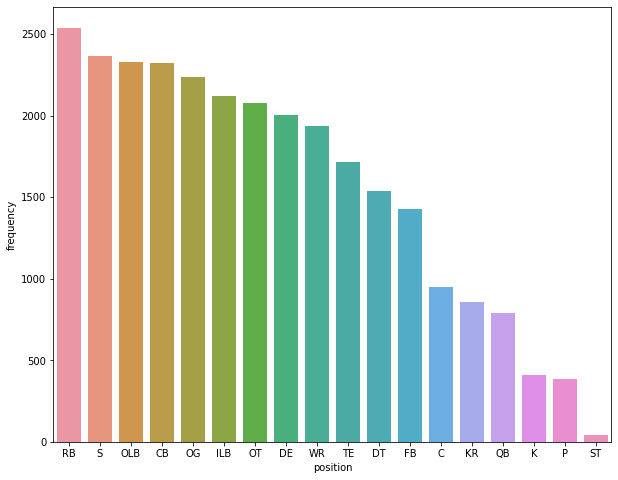

In [16]:
positions = pandas.read_sql_query('''
    SELECT position, count(*) as frequency
    FROM players JOIN player_positions USING (player)
    GROUP BY position
    ORDER BY frequency DESC
''', database)
pyplot.figure(figsize=(10, 8))
plot = seaborn.barplot(x='position', y='frequency', data=positions)
pyplot.show()

Now, let's see what positions are the most often injured. At first glance, it certainly appears that defensive players are getting injured more often. But, we have not yet weighed these occurrences against how many players are available for each of these positions.

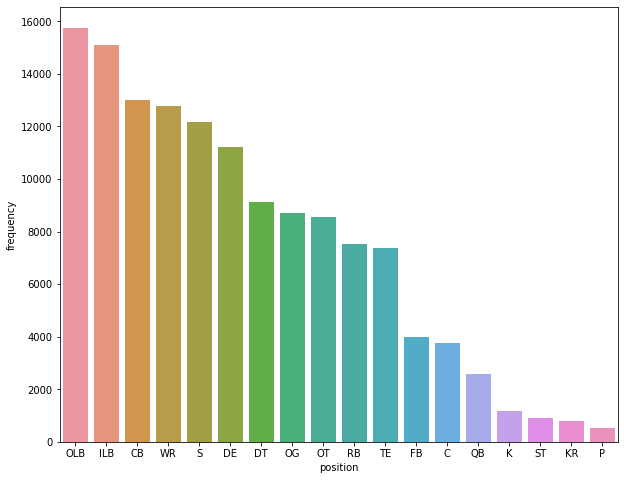

In [17]:
injuries_by_positions = pandas.read_sql_query('''
    SELECT position, count(*) AS frequency FROM
    injuries LEFT JOIN player_positions USING (player)
    GROUP BY position
    ORDER BY frequency DESC
''', database)
pyplot.figure(figsize=(10, 8))
plot = seaborn.barplot(x='position', y='frequency', data=injuries_by_positions)
pyplot.show()